# `crevopt` example notebook

This Jupyter Notebook contains a minimal working example of how `crevopt` can be used to extract crevasse information from Band 8 Sentinel-2 imagery, following Van Wyk de Vries _et al._ (2023).

> Van Wyk de Vries, M., Lea, J. M., & Ashmore, D. W. (2023). Crevasse density, 
orientation and temporal variability at Narsap Sermia, Greenland. Journal of Glaciology, 
69(277), 1125–1137. doi:https://doi.org/10.1017/jog.2023.3

As well as `crevopt`, we will be using `rioxarray` to load and export geotiff data, and `matplotlib` for plotting.

In [1]:
import os

import rioxarray as rxr
import matplotlib.pyplot as plt

import crevopt

# matplotlib/notebook viewing settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load scene

Sample data is contained within the `sample_data` directory of this notebook. It includes a band 8 (near infra-red) Sentinel-2 image of Store Glacier, Greenland (`20180701_B08.tif`) and an equivalent ice mask of the region (`promice_mask.tif`) of the same resolution and extent, with values set to `1` where the surface is valid ice is and `0` where invalid bedrock/ocean. The mask is extracted from the [PROMICE-2022 Ice Mask](https://doi.org/10.22008/FK2/O8CLRE).

In [2]:
data_dir = 'sample_data'

scene = rxr.open_rasterio(os.path.join(data_dir, '20180701_B08.tif')).squeeze()
mask = rxr.open_rasterio(os.path.join(data_dir, 'promice_mask.tif')).squeeze()

# Ensure 'scene' has a valid crs metadata
scene = scene.rio.write_crs(3413)

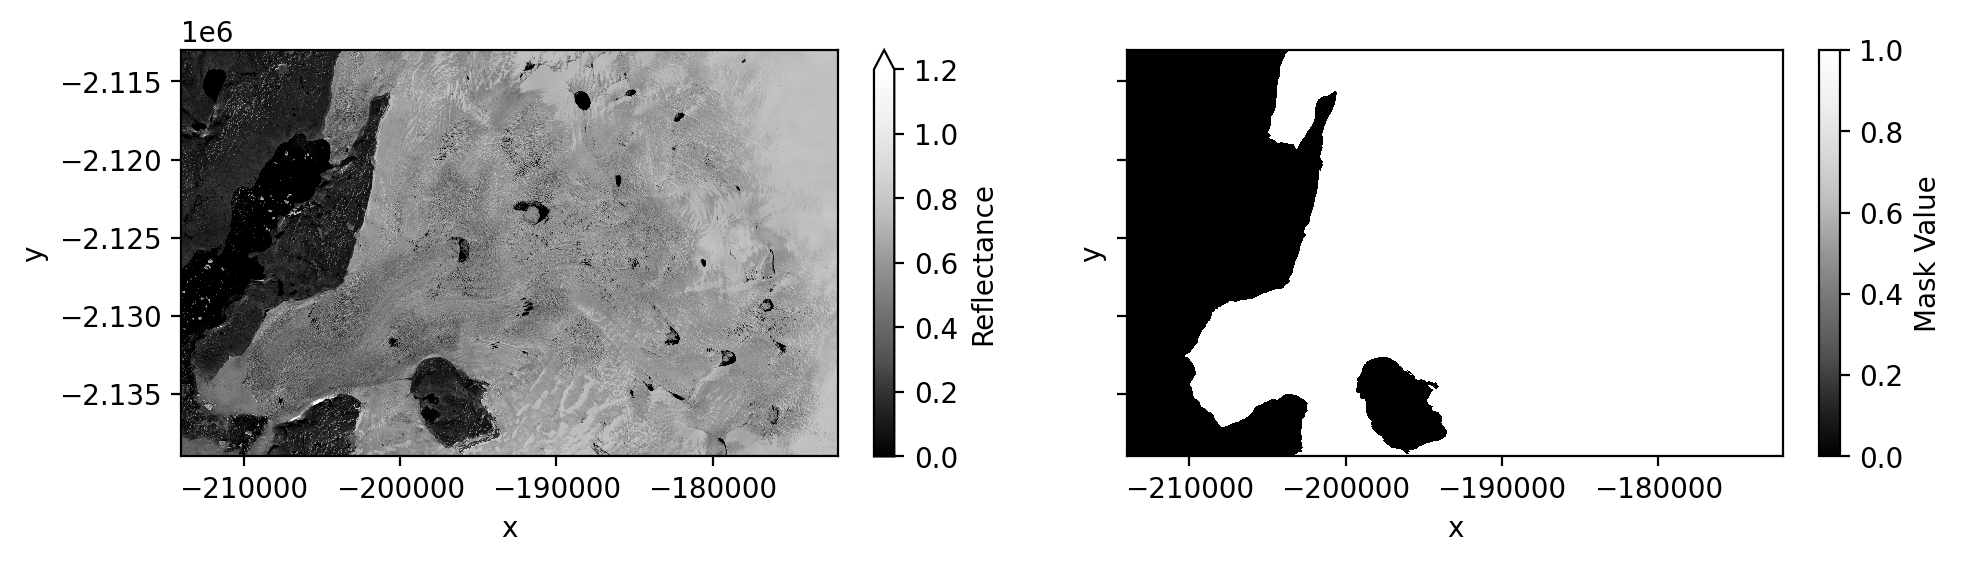

In [3]:
plt.close()
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, layout='constrained', figsize=(10,2.7))

ax = axes[0]
scene.plot.imshow(ax=ax, cmap='Greys_r', vmin=0, vmax=1.2, cbar_kwargs={'label': 'Reflectance'})

ax = axes[1]
mask.plot.imshow(ax=ax, cmap='Greys_r', vmin=0, vmax=1, cbar_kwargs={'label': 'Mask Value'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    ax.set_title(None)

plt.show()

## Apply crevasse detection method

The primary gabor filter algorithm can be run using the `crevopt.gabor_filter()` function. With all values left at the default Van Wyk de Vries _et al._ (2023) values (recommended for Sentinel-2 imagery), then the only parameter necessary to apply is the Sentinel 2 band, either as a `numpy.ndarray` or an `xarray.DataArray` (results will be returns in a matching format). On this dataset and my laptop, this takes ~10 s to run.

In [4]:
likelihood, orientation = crevopt.gabor_filter(scene)

The results come as the `likelihood`, which is the normalised maximum phase angle value of the Gabor responses across all directions, and the `orientation`, which is the dominant line/crevasse orientation, in degrees clockwise from North.

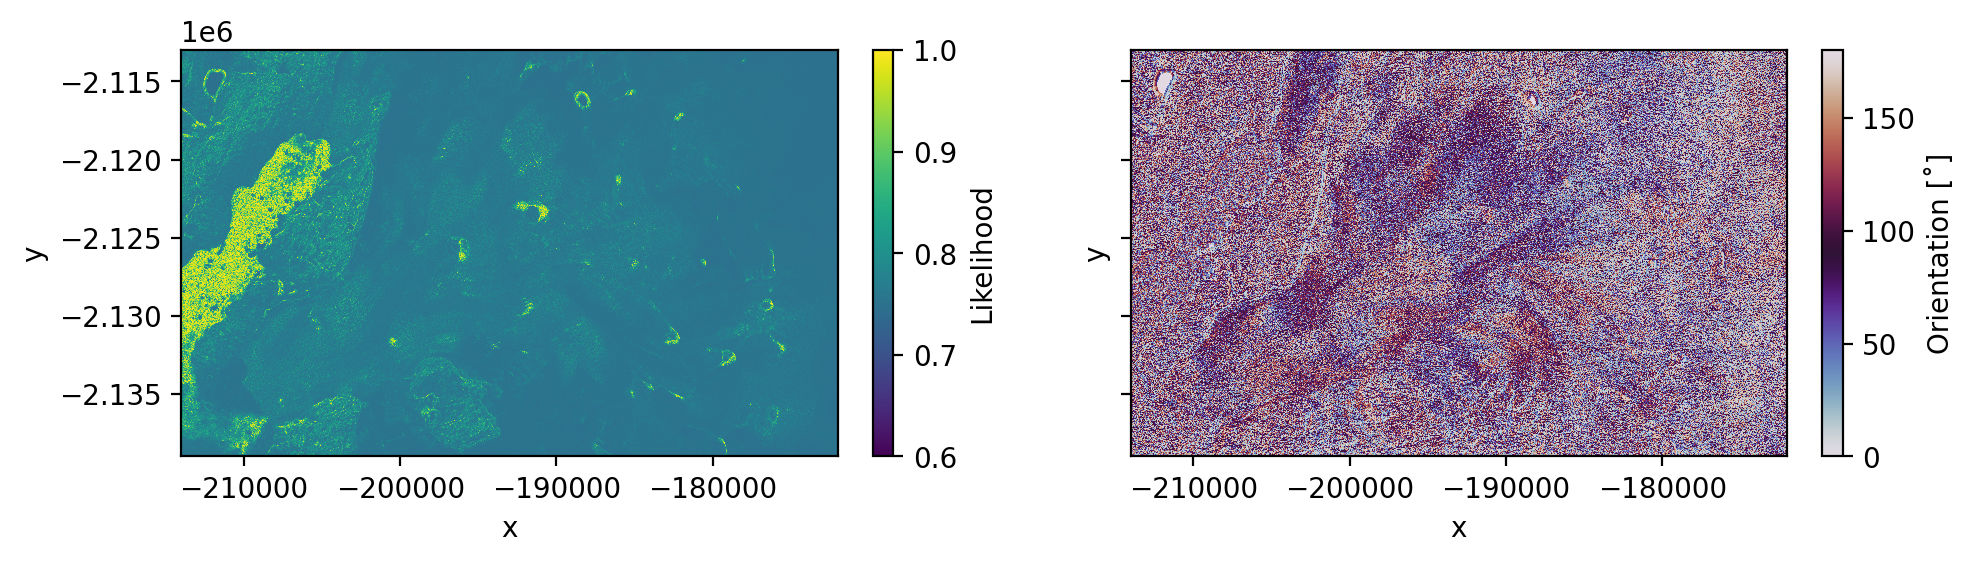

In [5]:
plt.close()
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, layout='constrained', figsize=(10,2.7))

ax = axes[0]
likelihood.plot.imshow(ax=ax, cmap='viridis', vmin=0.6, vmax=1, cbar_kwargs={'label': 'Likelihood'})

ax = axes[1]
orientation.plot.imshow(ax=ax, cmap='twilight', vmin=0, vmax=180, cbar_kwargs={'label': 'Orientation [˚]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    ax.set_title(None)

plt.show()

The next necessary step is to filter these values to only what we think are crevasses. This is done in a simple and convenient manner using the `crevopt.crevasse_mask()` function. This identifies crevasses by setting a likelihood threshold of $[1.25 \textnormal{ median}(C_L)]$, where $C_L$ is the crevasse likelihood. 

However, this is kept as a seperate function because the exact threshold value (set to 1.25 in the original Van Wyk de Vries algorithm) is quite sensitive to the local context. In the image above, you can see that supraglacial lakes have artifically high $C_L$ values, which results in the threshold of 1.25 being quite high. With a qualitatively chosen threshold of 1.03, we achieve much better results. 

In [6]:
likelihood_masked, orientation_masked = crevopt.crevasse_mask(likelihood, orientation, threshold=1.03, mask=mask)

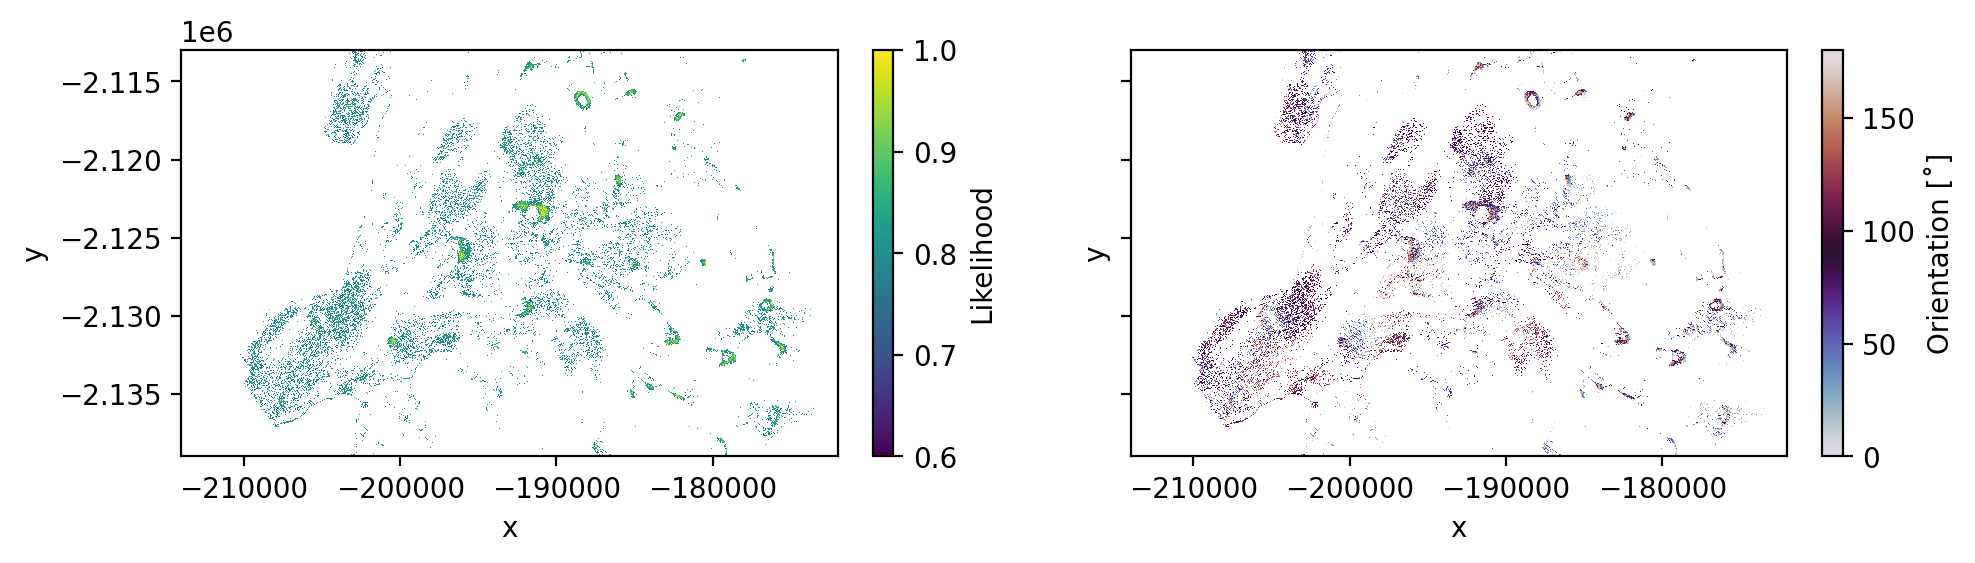

In [7]:
plt.close()
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, layout='constrained', figsize=(10,2.7))

ax = axes[0]
likelihood_masked.plot.imshow(ax=ax, cmap='viridis', vmin=0.6, vmax=1, cbar_kwargs={'label': 'Likelihood'})

ax = axes[1]
orientation_masked.plot.imshow(ax=ax, cmap='twilight', vmin=0, vmax=180, cbar_kwargs={'label': 'Orientation [˚]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    ax.set_title(None)

plt.show()

It might be slightly easier to see the data quality if we zoom in...

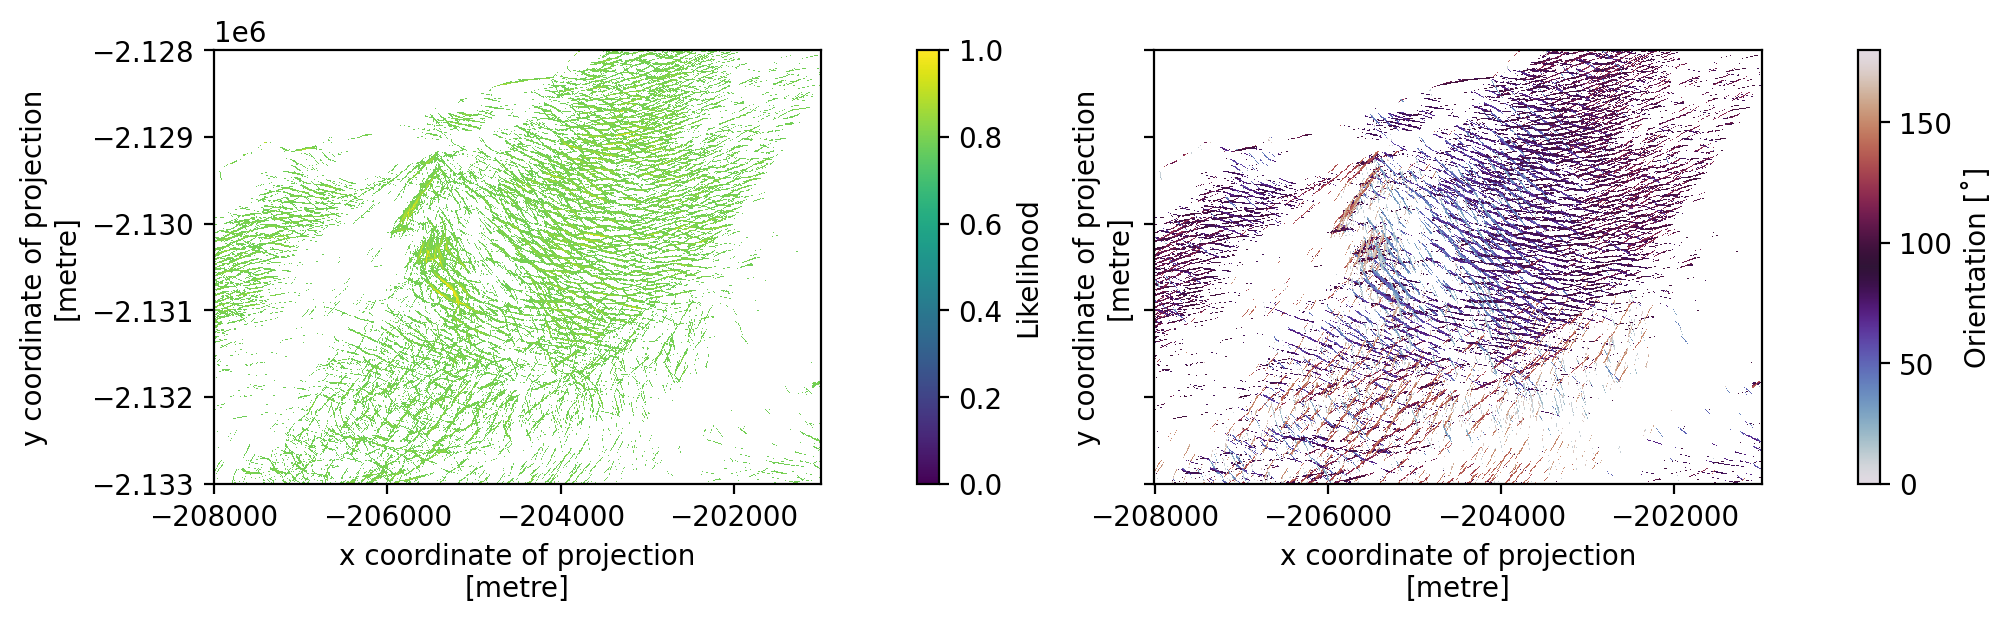

In [8]:
bbox = -208000, -2.133e6, -201000, -2.128e6

plt.close()
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, layout='constrained', figsize=(10,3.0))

ax = axes[0]
likelihood_masked.rio.clip_box(*bbox).plot.imshow(ax=ax, cmap='viridis', vmin=0, vmax=1, cbar_kwargs={'label': 'Likelihood'})

ax = axes[1]
orientation_masked.rio.clip_box(*bbox).plot.imshow(ax=ax, cmap='twilight', vmin=0, vmax=180, cbar_kwargs={'label': 'Orientation [˚]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    ax.set_title(None)

plt.show()

To achieve further oversight, we can get 'binned' statistics within a given window size (by default, 20 px):

1. The crevasse spatial density (proportion of pixels in the subregion identified as crevasses).
2. The median crevasse orientation.
3. The mean absolute deviation of the measured crevasse orientation.

We can do this using the `crevopt.binned_statistics()` function.

In [9]:
proportion, median_orientation, mad_orientation = crevopt.binned_statistics(likelihood_masked, orientation_masked)  # default window_size=20 px

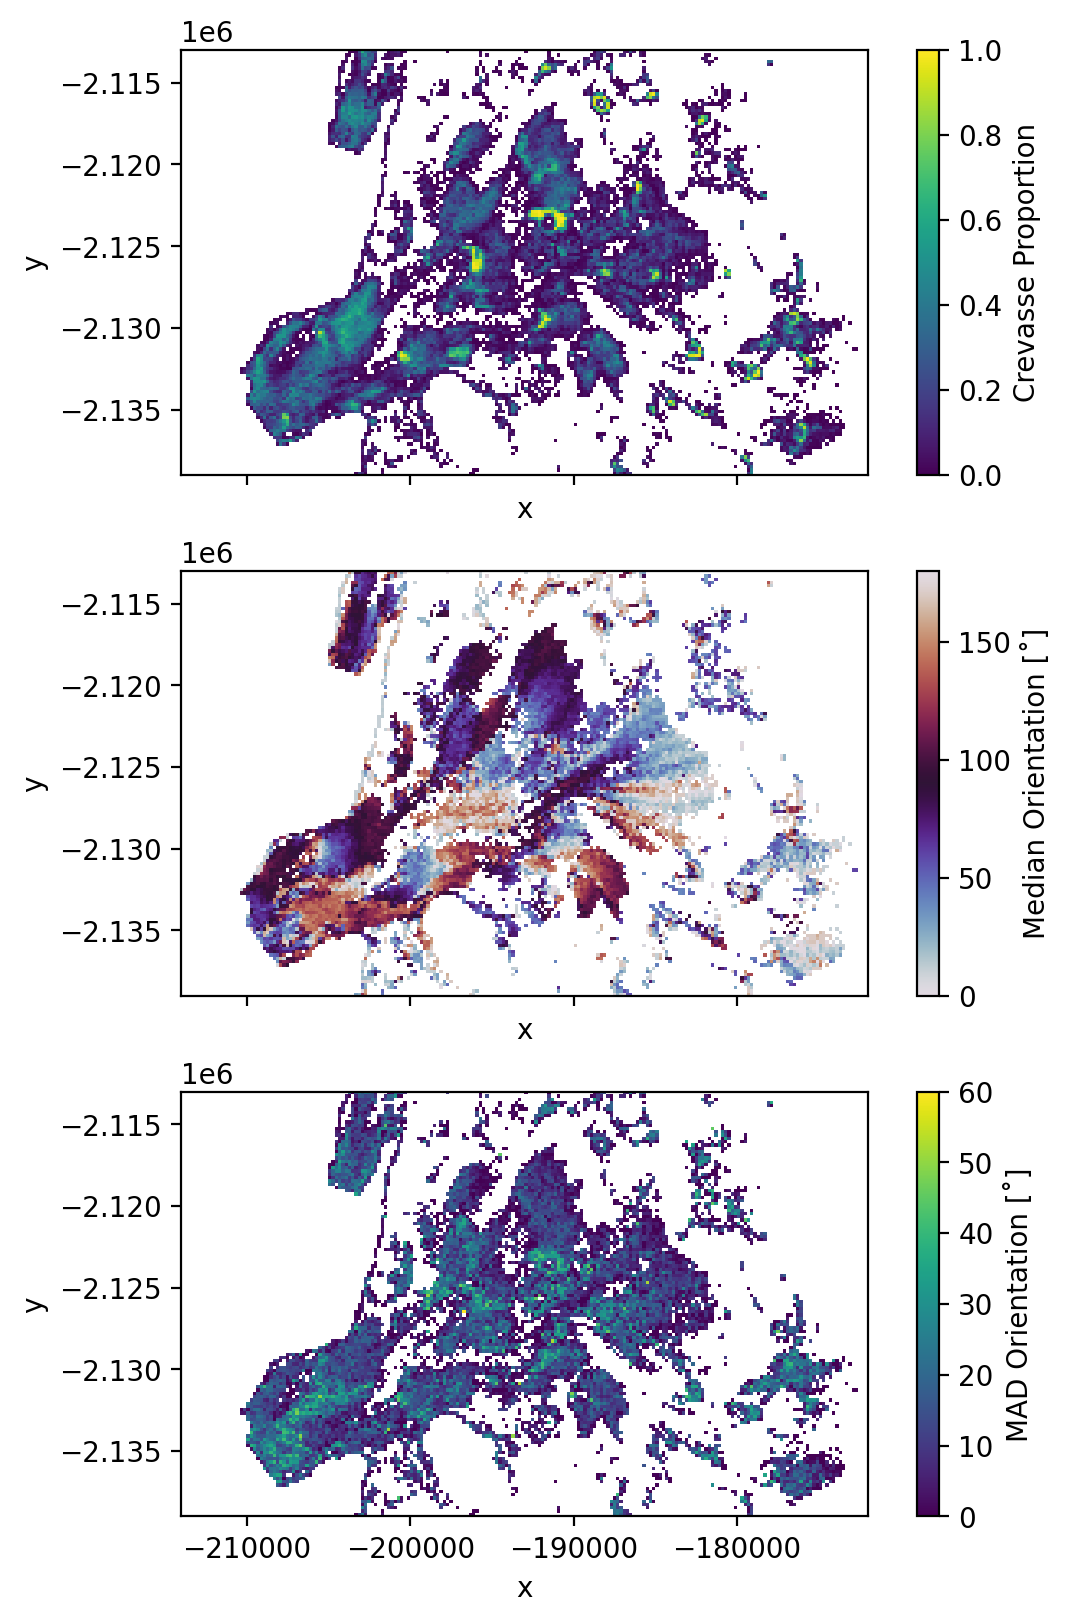

In [10]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, layout='constrained', figsize=(6,8))

ax = axes[0]
proportion.where(proportion>0).plot.imshow(ax=ax, cmap='viridis', vmin=0, vmax=1, cbar_kwargs={'label': 'Crevasse Proportion'})

ax = axes[1]
median_orientation.plot.imshow(ax=ax, cmap='twilight', vmin=0, vmax=180, cbar_kwargs={'label': 'Median Orientation [˚]'})

ax = axes[2]
mad_orientation.plot.imshow(ax=ax, cmap='viridis', vmin=0, vmax=60, cbar_kwargs={'label': 'MAD Orientation [˚]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    ax.set_title(None)

plt.show()

Because the data are `rioxarray` DataArrays, we can export them to geotiffs using `rioxarray` functionality - for example:

```python
orientation_masked.rio.to_raster(os.path.join('example_data', 'orientation_masked.tif'), driver='COG', compress='ZSTD', predictor=3, zlevel=1)
```